<center><img src='img/ms_logo.jpeg' height=40% width=40%></center>

<center><h1>Supervised Learning with Decision Trees</h1></center>

Now that we've built a classifier by hand, we have a general intuition behind the first Machine Learning algorithm we'll be using--[Decision Tree Classifiers](http://scikit-learn.org/stable/modules/tree.html#tree).  **_Decision Trees_** are considered one of the more mature, traditional algorithms in predictive analytics.  Although they can also be used for regression, you'll most likely see them used for classification problems.  

Before we begin using one in code, please take a few minutes to check out [this great tutorial](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) about how decision tress work.  
<br>
**_No, seriously.  Stop what you are doing and follow that link.  It contains one of the coolest visualizations of machine learning you'll ever see._**


<center><h3>A Brief Primer on Decision Trees</h3></center>

As explained in the SciKit-Learn user guide for this model, Decision Trees are "a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features." Let's explore what this means in plain English:

* Decision Trees are **_non-parametric_**.  This means that they make no underlying assumptions about the distribution of the dataset that they are working with.  Non-parametric models are not necessarily better or worse than parametric models, just better suited for different use cases.  

* Decision Trees can be used for **_Classification_** or **_Regression_**.  

* Decision Trees make predictions by combining a series of simple decisions based on what it sees in the training data. These decisions are nested, to form a tree. In the last exercise, when you wrote your classifier by hand, you probably did the same thing. For instance, it's not uncommon for students to explain their handmade model by saying somnething like "If the person I'm predicting for is a woman, I classify them as 'survived'.  If they're a man, I look at their ticket class.  If their ticket is 1st class, I predict they survived.  Otherwise, I predict they died".  These nested sets of decisions can be represented as a tree, hence the name--Decision Tree!

                                                        Male or Female?
                                                          /           \
                                                         /             \
                                                Ticket Class?           SURVIVED!
                                                /     |     \
                                            1st/   2nd|      \3rd
                                              /       |       \
                                        Survived     Died    Died
                                        
At the end of this notebook, we'll talk more deeply about the specifics of Decision Trees, and the benefits and drawbacks of this particular model.  For now, we'll start by importing the Titanic Dataset, cleaning it, and using a Decision Tree Classifier from the `SKLearn` library to make predictions on the data set!


<center><h3>Preparing the Data Set</h3></center>

We'll start by reading the dataset in using the `pandas` library.  After that, we'll take the following steps to prepare our dataset for use in a `DecisionTreeClassifier` from SKLearn.

**_TASK:_** Read in the `titanic.csv` dataset from the `/datasets` folder.  

In [580]:
# Run this cell to import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
np.random.seed(0)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO
import pydotplus

In [581]:
PATH = "./datasets/titanic.csv"
df = pd.read_csv(PATH)

Great! Now we need to 'clean' the dataset to get it ready for a Decision Tree.  This steps consists of:

1. Storing the 'Survived' column in a separate variable, and removing it from our Decision Tree.  This is what we are trying to predict, which means that we can't leave it in the dataset.  If we did, that would be like giving students the answer key along with the test--everyone would score 100% by default because of this column, and no actual learning would occur. 
<br>
<br>
2. Remove unecessary columns such as name, ticket number, etc.  Categorical features are fine, but features like name and ticket number provide no actual information, and will just confuse our algorithm.  Think about which columns should stay, and which should be dropped--in the cell below, we've provided a list of columns to drop for you. 
<br>
<br>
3.  Deal with NaN (null values).  In this case, we will deal with them just by dropping the entire row.  There are many other ways of dealing with NaNs, but they are outside the scope of this lesson.  
<br>
4. Convert categorical values to dummy columns (we've written this code for you).

In [582]:
# Drop columns that are not helpful
columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
df_with_cols_dropped = df.drop(columns_to_drop, axis=1)

In [583]:
# Use .dropna() to remove any rows that contain a null value
clean_df = df_with_cols_dropped.dropna()

# Use pd.get_dummies() on the clean_df object to create dummy columns for categorical variables. 
dummied_df = pd.get_dummies(clean_df)

# Give the dummy columns the prefix "is_" to make it clear that they are dummy varibles.
updated_column_names = [(column, "is_" + column) for column in dummied_df.iloc[:, 6:].columns.values]
dummied_df.rename(columns = dict(updated_column_names), inplace=True)

In [584]:
# Store the 'Survived' column in the 'labels' variable

class_label_vector = dummied_df["Survived"]

# Uncomment and run the code below to drop the 'Survived' column from the clean_df dataframe.  
dummied_df.drop("Survived", axis=1, inplace=True)
dummied_df
# Ignore the warning pandas gives you when you run this cell--everything is fine.  

,Pclass,Age,SibSp,Parch,Fare,is_Sex_female,is_Sex_male,is_Embarked_C,is_Embarked_Q,is_Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
6,1,54.0,0,0,51.8625,0,1,0,0,1
7,3,2.0,3,1,21.0750,0,1,0,0,1
8,3,27.0,0,2,11.1333,1,0,0,0,1
9,2,14.0,1,0,30.0708,1,0,1,0,0
10,3,4.0,1,1,16.7000,1,0,0,0,1


<center><h3>Recap: What We've Done So Far</h3></center>

We've now gone through the steps to 'clean' our dataset, and we're almost ready to begin using our Decision Tree Classifier. Let's look at what we've done so far.  

1.  Dropped the non-numeric columns.  We can safely assume that no useful information is contained in text-based columns such as name, cabin, etc, so we've dropped them.  
2.  Removed rows containing null values. 
3.  Used. `pd.get_dummies()` to convert categorical columns such as 'Sex' and 'Embarked' into columns for each category, with the category for the actual value containing a '1' while all other dummy columns for that category for that column will contain a '0'.
4.  Stored the labels in a separate data set.  It is important that we do this last.  Otherwise, any changes that we make to the corresponding rows in the dataframe will not be reflected in our labels variable.  For instance, if we stored labels in a separate variable and _then_ dropped rows from the dataframe that contain null values, we would still have those corresponding labels for the passengers we've dropped from the dataframe! Separating out our labels only works if the labels for each correspond to the row at the same index in the dataframe.

Here's what we'll do next: 

1. Import the appropriate tools from the `sklearn` library.  We need `train_test_split` to split our data set into training and testing sets,  the actual `DecisionTreeClassifier` model, and `f1_score` to tell us how we did.  
<br>
2.  Split our data into a **_Training Set_** and a **_Testing Set_**.  Our model will 'learn' on the training set, but we don't want to use this as a metric to tell us how well our model actually does.  In order to see how well our model actually 'learned' how to make predictions, we'll split off a portion of our data to hold out as a testing set.  Our model will make predictions on this data, which gives us a better signal as to whether our model is **_overfitting_**. We'll talk about the concept of **_overfitting_** and **_underfitting_** in a later class.  
<br> 
3.  We'll create a `DecisionTreeClassifier()` object.  
<br> 
4.  We'll `fit()` our model by feeding in our `X_Train` and `y_train` variables.  
<br>
5.  We'll ask our classifier object to make predictions for every object in the `X_test` variable.   
<br>
6.  We'll use the `f1_score` object to tell us how well our model made predictions by giving it the predictions made in the last step, as well as the actual labels for those data points, which are currently stored in `y_test`.  

In [593]:
# Redefine dataset names for generalization later on
X = dummied_df.iloc[:, -5:]
Y = class_label_vector

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
dtree = tree.DecisionTreeClassifier()

# Call clf.fit(), and pass in X_train and y_train as parameters
dtree = dtree.fit(X_train, Y_train)

# Use the .predict() method to have our model create predictions on the X_test variable
test_prediction = dtree.predict(X_test)

# Finally, pass in test_pred and y_test to the f1_score() object to get an f1_score!
# NOTE: F1-Score calculation assumes weighted average by label.
"{:.5g}".format(f1_score(test_prediction, Y_test, average="weighted"))



'0.8009'

In [586]:
# Visualize Iris dataset
dot_data = StringIO()

tree.export_graphviz(dtree, out_file=dot_data,
                         feature_names=X.columns,
                         class_names=["Survived", "Died"],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_jpg("dtree.jpg")

True

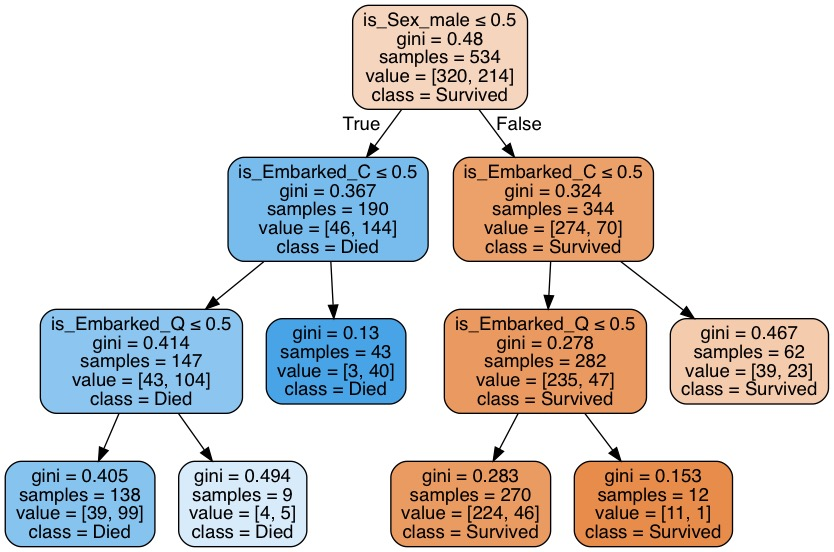

In [587]:
Image(filename="dtree.jpg")

In [588]:
# Playing around with SKLearn
roc_auc_score(Y_test, test_prediction, average="weighted")

0.75805613305613295

<center><h3>Branching Out on Your Own</h3></center>

Congratulations! You've now successfully used your first Machine Learning algorithm. VC's will now shower you with money any time you say "Machine Learning" out loud.

<center><img src='img/make_it_rain.gif'></center>

<center>Doing Supervised Learning, Unsupervised</center>

For the final challenge in this notebook, you'll use a decision tree classifier to make predictions on the Iris Dataset.  The process will be entirely the same as we did on the Titanic dataset, but easier because it requires less data cleaning.  (Hint: Take a look at the [sklearn.datasets](http://scikit-learn.org/stable/datasets/index.html) page to see if you can save yourself some time!)

Use a _Decision Tree Classifier_ to try and predict the class of each flower in the Iris dataset.  Use the same methodology you used for the Titanic dataset to get things up and running.

**_BONUS:_** See if you can **_visualize_** the Decision Tree you've created!  You can find example code on how to do this fairly easily on the [sklearn's documentation page for Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tree).  Here's an example of visualization from the page:

<center><img src='http://scikit-learn.org/stable/_images/iris.svg' height=75% width=75%></center>


In [589]:
# Import the Iris dataset from sklearn and use a decision tree classifier below!
iris = load_iris()
clf = tree.DecisionTreeClassifier()

X = iris.data[:, 2:]
Y = iris.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf = clf.fit(X_train, Y_train)

iris_prediction = clf.predict(X_test)

# NOTE: F1-Score calculation assumes weighted average by label.
"{:.5g}".format(f1_score(iris_prediction, Y_test, average="weighted"))

'0.96656'

In [590]:
# Visualize Iris dataset
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                         feature_names=iris.feature_names[2:],
                         class_names=iris.target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_jpg("iris.jpg")

True

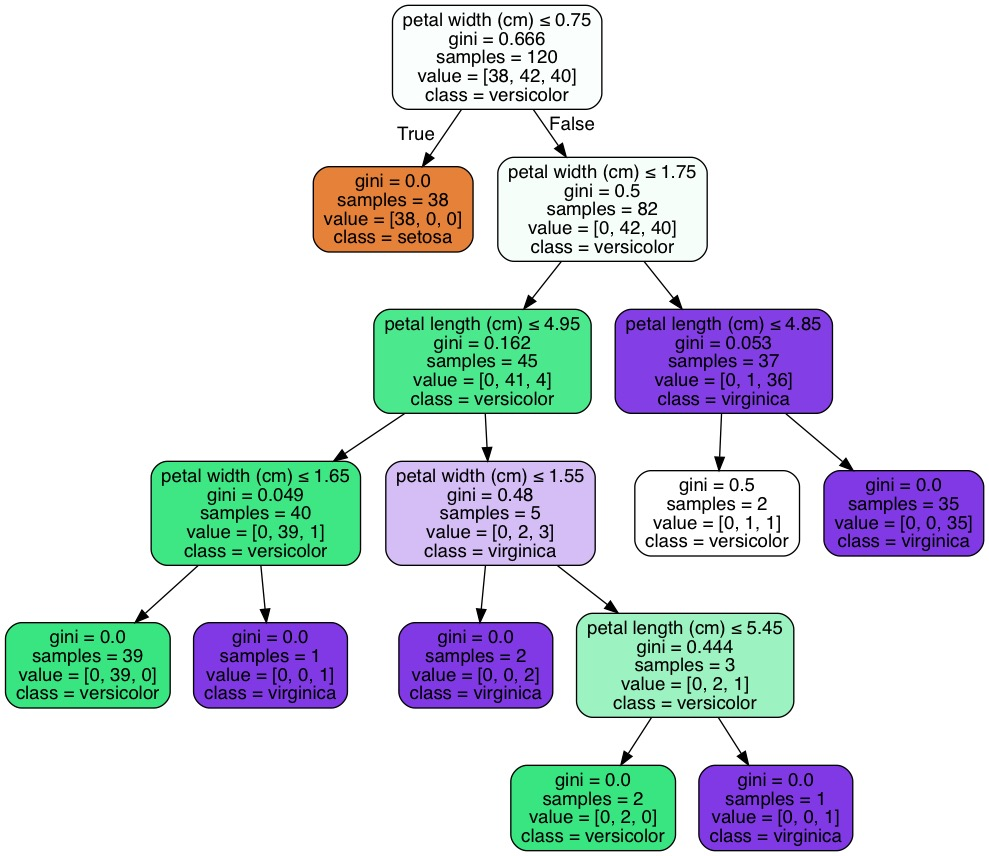

In [591]:
Image(filename="iris.jpg")